# Малютин Павел, ИТПЗ РАН
 

In [1]:
import pandas as pd
import math 
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from numba import jit, njit
from sklearn.linear_model import LinearRegression

# b-value calculating

In [2]:
'''чтение файла из директории проги
и устранение выбросов значений магнитуды округлением до 1 знака пз.'''
my_cat = pd.read_csv('./catalogues/DOUBLE_PREC_DD (2).csv', sep = ';') 
my_cat = my_cat.loc[my_cat.YEAR < 1985]
#my_cat = my_cat.loc[my_cat.latitude > 38.7751667]
#my_cat = my_cat.loc[my_cat.latitude < 38.8081667]
#my_cat = my_cat.loc[my_cat.longitude > -122.778]
#my_cat = my_cat.loc[my_cat.longitude < -122.733]
my_cat = my_cat.reset_index(drop = True)
my_cat.mag = round(my_cat.mag, 1)  
my_cat

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,latitude,longitude,depth,EH1,EH2,AZ,EV,mag,ID
0,1984,1,1,1,19,11.317,36.08781,-120.22869,10.897,0.020,0.010,96,0.022,1.8,1109386
1,1984,1,1,1,58,2.420,36.87608,-120.90669,2.661,0.071,0.018,55,0.421,0.0,346
2,1984,1,1,1,59,27.124,36.87000,-120.90889,1.592,0.110,0.016,66,0.727,1.5,1109389
3,1984,1,1,2,28,4.240,37.51546,-118.75485,7.703,0.020,0.008,37,0.024,1.2,1109391
4,1984,1,1,3,8,58.044,40.57227,-124.55933,20.407,1.009,0.083,103,0.080,2.0,1109392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21270,1984,12,31,21,44,17.740,38.79228,-122.77453,3.975,0.039,0.023,131,0.060,1.1,1124941
21271,1984,12,31,21,47,8.160,37.21852,-121.60970,3.779,0.003,0.003,46,0.007,0.7,36051
21272,1984,12,31,22,35,57.680,37.42411,-118.62705,6.234,0.014,0.010,20,0.027,1.1,36052
21273,1984,12,31,23,23,8.964,37.42794,-118.61264,12.437,0.024,0.014,11,0.030,1.6,1124943


In [3]:
from pathlib import Path  
filepath = Path('./results/my_cat.csv')
my_cat.to_csv(filepath)

Text(0.5, 0.98, 'График повторяемости землетрясений')

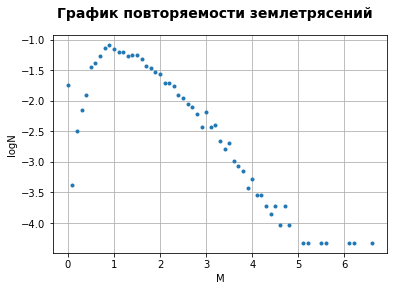

In [4]:
'''Следующий кусок вычисляет необходимые для построения графика повторяемости EQ параметры
а именно: N_tot - суммарное количество землетрясений
a - Series, состоящая из значений lg(N/N_tot) и соотвествующих магнитуд
и, собственно строит график ПЗ для оценки справедливости Г-Р.'''
N_tot = my_cat.shape
f = lambda x: math.log10(x/N_tot[0])
a = my_cat.mag.value_counts().apply(f)
a.plot(style='.')
plt.grid()
plt.xlabel("M")
plt.ylabel("logN")
plt.suptitle('График повторяемости землетрясений', 
             fontsize=14, fontweight='bold')
 # расчет b-value по формуле Aki
# mag - СТОЛБЕЦ С МАГНИТУДОЙ В ДАННОЙ csv


### Необходимо выбрать представительную магнитуду

In [6]:
M_0 = float(input())
my_cat = my_cat.loc[my_cat['mag'] > M_0]
my_cat = my_cat.reset_index(drop = True)
b_value = 1 / (my_cat['mag'].mean() - M_0) * (1/ math.log(10))
# расчет b-value по формуле Aki
# mag - СТОЛБЕЦ С МАГНИТУДОЙ В ДАННОЙ csv
print('\033[1m'+'b-value is:', b_value, ' ± ', b_value/math.sqrt(N_tot[0]))
my_cat
N_tot = my_cat.shape

1.2
b-value is: 0.653687015311375  ±  0.006498961786191572


# Fractal dimension
#### но, прежде всего, функция вычисления расстояния между землетрясениями


In [7]:
global Pi2, RAD, FLAT
Pi2 = math.pi/2 # тупо пи-на-два
RAD = 0.01745329 # DGR -> RAD
FLAT = 0.993231 # поправка на эллипсоидноть

In [8]:
def eq_dist (fi1, la1, fi2, la2, d1, d2): # fi - широта (latitude), la - долгота (longtitude)
    '''Функция позволяет вычислять расстояение между двумя точками земли с учетом сплюсности и глубины'''    
    #if ((fi1-fi2)==0 and (la1-la2)==0): #проверка на расстояние между одним и тем же землетрясением
    #    return (0.0)  
    col1 = Pi2 - math.atan(FLAT * math.tan(fi1 * RAD))
    col2 = Pi2 - math.atan(FLAT * math.tan(fi2 * RAD))
    
    dlon =  la2 * RAD - la1 * RAD
    
    cosdel = math.sin(col1) * math.sin (col2) * math.cos(dlon) + math.cos(col1) * math.cos(col2)
    delr = math.acos(cosdel)
    colat = Pi2 - (fi1 * RAD + fi2 * RAD) / 2.0
    distan_eq =  math.sqrt((delr * 6371.227 * (1.0 + 0.00337853 * (1./3. -((math.cos(colat))*math.cos(colat)))))**2 + (d2-d1)**2)
    if distan_eq == 0:
        distan_eq = 0.01
    return distan_eq

## Непосредственный расчёт фрактальной размерности

In [9]:
'''создание numpy-array для более быстрого обращения [к памяти]
в цикле к соответствующим значениям широты и долготы'''
latitude = my_cat.latitude.to_numpy()
longitude = my_cat.longitude.to_numpy()
depth = my_cat.depth.to_numpy()

In [10]:
'''Вместо того, чтобы каждый раз перебирать для каждого заданного расстояния между
землетрясениями все возможные пары расстояний, в самом начале создается массив
с этими парами. Это существенно сокращает время выполнения программы'''

array_of_dist = [[0] * N_tot[0] for i in range(N_tot[0])]

for i in tqdm(range((N_tot[0]))):
    for j in range(i+1, N_tot[0]):
        #array_of_dist.append(eq_dist(latitude[k], longitude[k], latitude[j], longitude[j], depth[k], depth[j]))
        array_of_dist[i][j] = eq_dist(latitude[i], longitude[i], latitude[j], longitude[j], depth[i], depth[j])
        array_of_dist[j][i] = array_of_dist[i][j]
np.save('array_o_dist', array_of_dist)

100%|████████████████████████████████████| 10117/10117 [06:59<00:00, 24.14it/s]


In [11]:
fractalka = pd.DataFrame(dtype='float')  #ДФ с lg(N/N_0) и lg(A)
X = np.linspace(0.1,3,24) #задает равномерно распределенный массив возможных расстояний м/у ЗТ
element_count = 0
total_pairs = N_tot[0]*(N_tot[0]-1)/2    #общее количество пар землетрясений 
for i in tqdm(X):  
    for n in range(N_tot[0]):
        for m in range(n+1, N_tot[0]):
            if array_of_dist[n][m] < i:
                element_count += 1
    fractalka = pd.concat([fractalka, pd.DataFrame ([math.log10(element_count/total_pairs)],[math.log10(i)])])
    element_count = 0

    

100%|██████████████████████████████████████████| 24/24 [06:55<00:00, 17.31s/it]


Text(0, 0.5, 'log(N/N_0)')

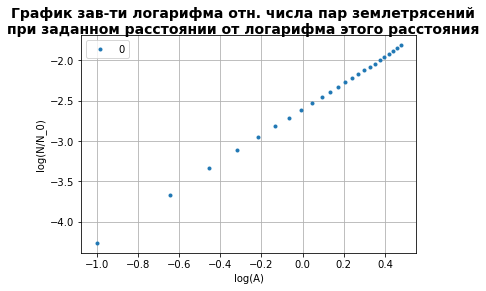

In [14]:
fractalka.plot(style='.')
plt.suptitle('График зав-ти логарифма отн. числа пар землетрясений' '\nпри заданном расстоянии от логарифма этого расстояния', 
             fontsize=14, fontweight='bold')
plt.grid()
plt.xlabel("log(A)")
plt.ylabel("log(N/N_0)")

Fractal dimension is 1.6344783067403161


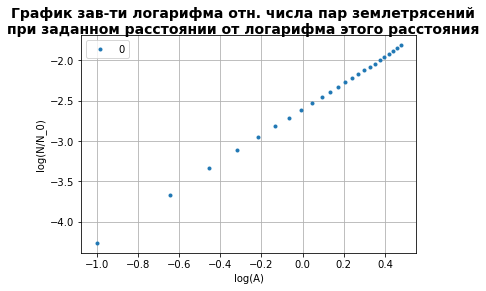

In [17]:
fractalka.plot(style='.')
plt.suptitle('График зав-ти логарифма отн. числа пар землетрясений' '\nпри заданном расстоянии от логарифма этого расстояния', 
             fontsize=14, fontweight='bold')
plt.grid()
plt.xlabel("log(A)")
plt.ylabel("log(N/N_0)")
X = fractalka.index.to_numpy().reshape(-1, 1)
Y = fractalka[0].to_numpy().reshape(-1, 1)
linear_model_d = LinearRegression()
linear_model_d.fit(X, Y)
d_f = linear_model_d.coef_[0][0] # фрактальная размерность
print('\033[1m' + 'Fractal dimension is', d_f)

# Функция близости

In [18]:
print("b-value is               ", round(b_value,3))
print("d_f is                   ", round(d_f,3))
print("Minimal magnitude M_0 is ", M_0)

b-value is                0.654
d_f is                    1.634
Minimal magnitude M_0 is  1.2


In [19]:
n_ = [[float('inf')] * N_tot[0] for i in range(N_tot[0])]
T_ = [[0] * N_tot[0] for i in range(N_tot[0])]

In [20]:
my_cat.SECOND = my_cat.SECOND.astype(int)
import datetime
year = my_cat.YEAR.to_numpy()
month = my_cat.MONTH.to_numpy()
day = my_cat.DAY.to_numpy()
hour = my_cat.HOUR.to_numpy()
minute = my_cat.MINUTE.to_numpy()
second = my_cat.SECOND.to_numpy()

### Функция для рассчёта времени между зт

In [21]:
@jit 
def time_in_seconds (i, j):
    t_i = datetime.datetime(year[i], month[i], day[i], hour[i], minute[i], second[i])
    t_j = datetime.datetime(year[j], month[j], day[j], hour[j], minute[j], second[j])
    t_ij = (t_i - t_j).total_seconds()
    if t_ij == 0:
        return -0.1
    return -t_ij

In [22]:
for i in tqdm(range(N_tot[0]-1,-1,-1)):
    for j in range(i,-1,-1):
        T_[i][j] = -time_in_seconds(i,j)
        T_[j][i] = T_[i][j]

  0%|                                                | 0/10117 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_11252\352664844.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "time_in_seconds" failed type inference due to: Unknown attribute 'datetime' of type Module(<module 'datetime' from 'C:\\Users\\admin\\anaconda3\\lib\\datetime.py'>)

File "..\..\..\AppData\Local\Temp\ipykernel_11252\352664844.py", line 3:
<source missing, REPL/exec in use?>

During: typing of get attribute at C:\Users\admin\AppData\Local\Temp\ipykernel_11252\352664844.py (3)

File "..\..\..\AppData\Local\Temp\ipykernel_11252\352664844.py", line 3:
<source missing, REPL/exec in use?>

  @jit
C:\Users\admin\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "time_in_seconds" was compiled in object mode without forceobj=True.

File "..\..\..\AppData\Local\Temp\ipykernel_11252\352664844.py", line 1:
<source mis

In [23]:
for i in tqdm(range(N_tot[0])):
    for j in range(i,N_tot[0]): #ВНИМАНИЕ - ХЗ ПОЧЕМУ ОТ И БЕРУ. ХОЧУ ПРОВЕРИТЬ
        if i == j:
            continue
        n_[j][i] = abs(T_[j][i])*(array_of_dist[i][j]**d_f)*(10**((-b_value)*my_cat.mag[i]))
        #n_[j][i] = n_[i][j]
        

100%|████████████████████████████████████| 10117/10117 [21:01<00:00,  8.02it/s]


In [24]:
np.save('n_', n_)


In [25]:
array_of_dist[1048]


[207.55974312817702,
 195.4933151281249,
 586.0119060118765,
 202.26435870297286,
 229.37471262528524,
 363.7378077235014,
 390.31637778022326,
 554.4686495776187,
 203.24253055918115,
 236.18802739866626,
 247.59877254189436,
 11.579367727038306,
 195.47920273597026,
 199.07287943746897,
 16.914402303696985,
 195.68656290252156,
 107.96232082812753,
 364.0289628944713,
 81.62862387654464,
 363.75592458794927,
 13.019291722075652,
 199.1961116233976,
 341.30287366742107,
 497.5004458604462,
 199.68098336334077,
 325.32322714341876,
 197.2352193080604,
 201.16714342951556,
 205.68502454926198,
 4.456688739973746,
 567.0271936283407,
 562.1030937482791,
 361.40138019315395,
 199.74926859664242,
 203.30947148665584,
 460.01339597179026,
 200.01485444006804,
 199.79784715802217,
 199.92054086117585,
 200.17862494890215,
 130.37978486446323,
 361.2209895675406,
 232.7480004826221,
 130.8395120007102,
 14.356055386622065,
 2.64804085888882,
 237.1052905146034,
 291.5537777888784,
 252.637670

In [26]:
n_[2]

[16301970.79643961,
 11977364.494396348,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,

In [27]:
N = [0] * N_tot[0]
D = [0] * N_tot[0]
for i in range(len(n_)):
    D[i] = round(math.log10((min(n_[i][:]))),1)
    N[i] = n_[:][i].index(min(n_[i][:]))
resultate = pd.DataFrame({'Closest_neigh':D, 'Index_o_CN':N})

In [28]:
resultate
from pathlib import Path  
filepath = Path('./results/nearest_dist_n_index.csv')
resultate.to_csv(filepath)

In [29]:
Dist_to_Nearest = resultate.Closest_neigh.value_counts(normalize=True)
from pathlib import Path  
filepath = Path('./results/nearest_dist.csv')
Dist_to_Nearest.to_csv(filepath)

In [ ]:
Dist_to_Nearest